In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Reshape, multiply
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.layers.core import Lambda
from keras.utils.vis_utils import plot_model
from tensorflow.python.framework import ops
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D

import keras.backend as K
from keras import optimizers
import random
import sys
import cv2
import os
from skimage import io
import tensorflow as tf
import numpy as np
from keras.models import load_model
from keras import initializers
from keras.callbacks import ModelCheckpoint, EarlyStopping

import csv
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

category_num=3
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" 
config = tf.compat.v1.ConfigProto(log_device_placement=True, device_count={"CPU":4},
inter_op_parallelism_threads=4,
intra_op_parallelism_threads=2,
allow_soft_placement=True)

Number of images in train set :  2993
Number of images in test set :  643
Number of images in val set :  642


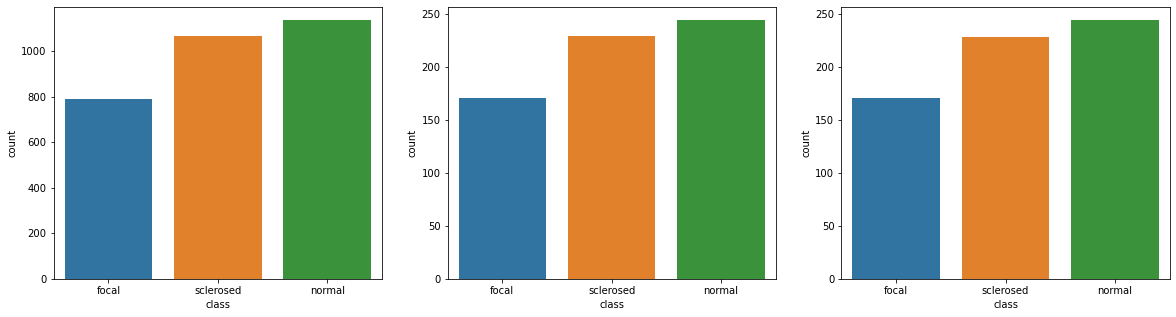

In [2]:
root_path = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/'
train_pred_test_folders = os.listdir(root_path)

train_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/train/' #one more seg_train folder within
test_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/test/'
val_folders = '/media/ai1/1337af50-4ca0-4065-8fbe-0e8c353e7de8/Fauzan_Research/glomeruli dataset/auto_split/val/'
quantity_tr = {} 
quantity_te = {}
quantity_va = {}
for folder in os.listdir(train_folders):
    quantity_tr[folder] = len(os.listdir(train_folders+folder))

for folder in os.listdir(test_folders):
    quantity_te[folder] = len(os.listdir(test_folders+folder))

for folder in os.listdir(val_folders):
    quantity_va[folder] = len(os.listdir(val_folders+folder))

quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_te.items()), index=range(0,len(quantity_te)), columns=['class','count'])
quantity_val = pd.DataFrame(list(quantity_va.items()), index=range(0,len(quantity_va)), columns=['class','count'])

figure, ax = plt.subplots(1,3,figsize=(20,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])
sns.barplot(x='class',y='count',data=quantity_val,ax=ax[2])
#sns.barplot(x='class',y='count',data=quantity_new_data,ax=ax[3])

print("Number of images in train set : ", sum(quantity_tr.values()))
print("Number of images in test set : ",sum(quantity_te.values()))
#number_of_images_in_prediction_set = len(os.listdir(seg_pred_folders))
print("Number of images in val set : ",sum(quantity_va.values()))
#print("Number of images in new dataset : ",sum(quantity_ne.values()))

plt.show()

In [3]:
category_num=3
BUFFER_SIZE = len(train_folders)
IMG_SIZE = 256

In [4]:
train_datagen = ImageDataGenerator(rescale = 1.0/IMG_SIZE)
validation_datagen = ImageDataGenerator(rescale = 1.0/IMG_SIZE)
test_datagen = ImageDataGenerator(rescale = 1.0/IMG_SIZE)

In [5]:
def train(BATCH_SIZE):
    train_generator = train_datagen.flow_from_directory(train_folders,
                                                        batch_size=BATCH_SIZE,
                                                        shuffle=BUFFER_SIZE,
                                                        class_mode='categorical',
                                                        target_size=(IMG_SIZE, IMG_SIZE))
    return train_generator

In [6]:
def validation(BATCH_SIZE):
    
    validation_generator = validation_datagen.flow_from_directory(val_folders, 
                                                                  shuffle=BUFFER_SIZE, 
                                                                  batch_size=BATCH_SIZE, 
                                                                  class_mode='categorical', 
                                                                  target_size=(IMG_SIZE, IMG_SIZE))
    return validation_generator

In [7]:
def test(BATCH_SIZE):
    test_generator = test_datagen.flow_from_directory(test_folders,
                                                      batch_size=BATCH_SIZE,
                                                      shuffle=BUFFER_SIZE,
                                                      class_mode='categorical',
                                                      target_size=(IMG_SIZE, IMG_SIZE))
    return test_generator

In [8]:
def show_few_images(number_of_examples, predict_using_model):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(train_folders)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(train_folders)):
        image_ids = os.listdir(os.path.join(train_folders,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            path = os.path.join(train_folders,folder,image_ids[j])
            display = cv2.resize(cv2.imread(path),(IMG_SIZE,IMG_SIZE))
            display = display/IMG_SIZE
            
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                predicted_classname = inv_map_classes[np.argmax(predict_using_model.predict(np.array([display])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1

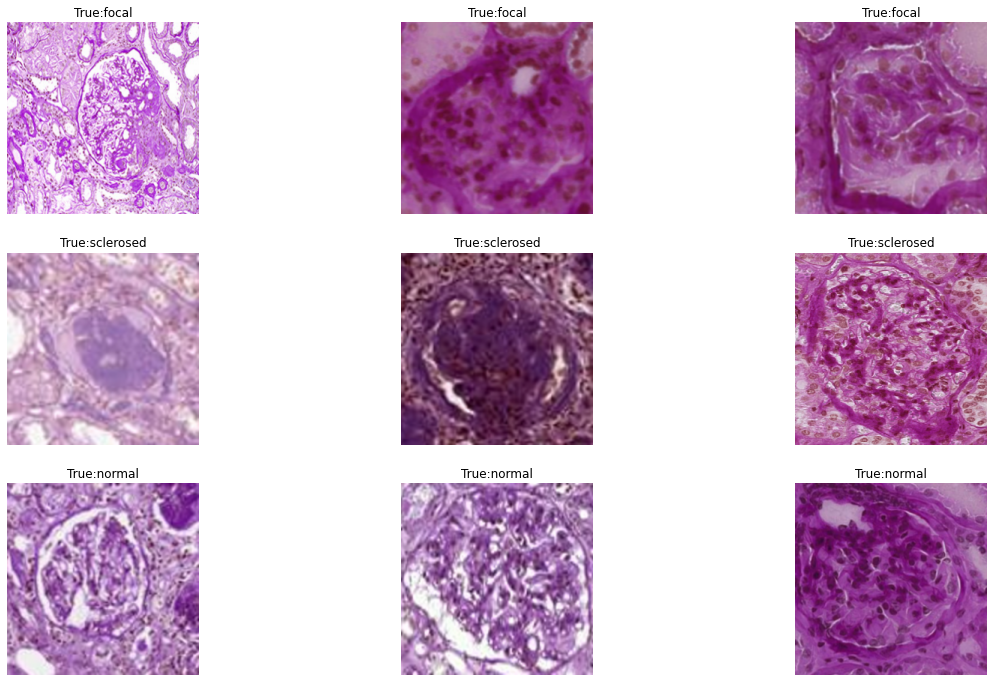

In [9]:
show_few_images(3,None)

In [10]:
strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")

In [11]:
with strategy.scope():
    model = tf.keras.applications.VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
    for layers in model.layers:
                layers.trainable=False
    last_output = model.layers[-1].output
    output = Flatten()(last_output)
    output = Dense(128, activation = 'relu')(output)
    output = Dense(3, activation = 'softmax')(output)
    model = Model(model.input, output)
    model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])

In [12]:
data_train = train(1)
data_validation = validation(1)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=5,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/5
2993/2993 [==============================] - 1062s 355ms/step - loss: 0.7368 - acc: 0.6579 - val_loss: 0.3826 - val_acc: 0.8411
Epoch 2/5
2993/2993 [==============================] - 989s 331ms/step - loss: 0.3929 - acc: 0.8347 - val_loss: 0.3133 - val_acc: 0.8816
Epoch 3/5
2993/2993 [==============================] - 1252s 418ms/step - loss: 0.3176 - acc: 0.8742 - val_loss: 0.2436 - val_acc: 0.9112
Epoch 4/5
2993/2993 [==============================] - 1185s 396ms/step - loss: 0.3033 - acc: 0.8790 - val_loss: 0.2821 - val_acc: 0.8956
Epoch 5/5
2993/2993 [==============================] - 1288s 430ms/step - loss: 0.2410 - acc: 0.9023 - val_loss: 0.2111 - val_acc: 0.9346


In [13]:
data_test = test(1)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
643/643 [==============================] - 234s 364ms/step - loss: 0.2166 - acc: 0.9129


[0.2165919542312622, 0.9129082560539246]

In [12]:
data_train = train(2)
data_validation = validation(2)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=5,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/5
1497/1497 [==============================] - 327s 218ms/step - loss: 0.7608 - acc: 0.6429 - val_loss: 0.3781 - val_acc: 0.8551
Epoch 2/5
1497/1497 [==============================] - 384s 256ms/step - loss: 0.4218 - acc: 0.8214 - val_loss: 0.3504 - val_acc: 0.8676
Epoch 3/5
1497/1497 [==============================] - 405s 271ms/step - loss: 0.3119 - acc: 0.8745 - val_loss: 0.2834 - val_acc: 0.8988
Epoch 4/5
1497/1497 [==============================] - 399s 267ms/step - loss: 0.2714 - acc: 0.8940 - val_loss: 0.2360 - val_acc: 0.9159
Epoch 5/5
1497/1497 [==============================] - 282s 188ms/step - loss: 0.2493 - acc: 0.9005 - val_loss: 0.2280 - val_acc: 0.9143


In [13]:
data_test = test(2)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
322/322 [==============================] - 47s 146ms/step - loss: 0.2547 - acc: 0.8958


[0.25472185015678406, 0.8958009481430054]

In [14]:
data_train = train(4)
data_validation = validation(4)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=5,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/5
749/749 [==============================] - 254s 339ms/step - loss: 0.2040 - acc: 0.9201 - val_loss: 0.2036 - val_acc: 0.9315
Epoch 2/5
749/749 [==============================] - 250s 333ms/step - loss: 0.1991 - acc: 0.9218 - val_loss: 0.3063 - val_acc: 0.8925
Epoch 3/5
749/749 [==============================] - 249s 332ms/step - loss: 0.1956 - acc: 0.9225 - val_loss: 0.2083 - val_acc: 0.9268
Epoch 4/5
749/749 [==============================] - 248s 332ms/step - loss: 0.1835 - acc: 0.9228 - val_loss: 0.2009 - val_acc: 0.9299
Epoch 5/5
749/749 [==============================] - 249s 333ms/step - loss: 0.1772 - acc: 0.9275 - val_loss: 0.2820 - val_acc: 0.8894


In [15]:
data_test = test(4)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
161/161 [==============================] - 44s 273ms/step - loss: 0.2991 - acc: 0.8709


[0.29914966225624084, 0.870917558670044]

In [12]:
data_train = train(8)
data_validation = validation(8)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=5,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/5
375/375 [==============================] - 290s 772ms/step - loss: 0.8100 - acc: 0.6311 - val_loss: 0.4745 - val_acc: 0.8069
Epoch 2/5
375/375 [==============================] - 317s 845ms/step - loss: 0.4818 - acc: 0.8033 - val_loss: 0.4433 - val_acc: 0.8131
Epoch 3/5
375/375 [==============================] - 331s 881ms/step - loss: 0.3952 - acc: 0.8347 - val_loss: 0.3219 - val_acc: 0.8863
Epoch 4/5
375/375 [==============================] - 336s 896ms/step - loss: 0.3197 - acc: 0.8824 - val_loss: 0.3055 - val_acc: 0.8816
Epoch 5/5
375/375 [==============================] - 342s 911ms/step - loss: 0.2927 - acc: 0.8888 - val_loss: 0.3061 - val_acc: 0.8832


In [13]:
data_test = test(8)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
81/81 [==============================] - 60s 734ms/step - loss: 0.3116 - acc: 0.8725


[0.3115741014480591, 0.8724727630615234]

In [14]:
data_train = train(16)
data_validation = validation(16)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=5,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/5
188/188 [==============================] - 410s 2s/step - loss: 0.2605 - acc: 0.9008 - val_loss: 0.2533 - val_acc: 0.9112
Epoch 2/5
188/188 [==============================] - 454s 2s/step - loss: 0.2484 - acc: 0.9044 - val_loss: 0.2458 - val_acc: 0.9128
Epoch 3/5
188/188 [==============================] - 478s 3s/step - loss: 0.2351 - acc: 0.9091 - val_loss: 0.2262 - val_acc: 0.9268
Epoch 4/5
188/188 [==============================] - 483s 3s/step - loss: 0.2209 - acc: 0.9135 - val_loss: 0.2486 - val_acc: 0.9097
Epoch 5/5
188/188 [==============================] - 493s 3s/step - loss: 0.2162 - acc: 0.9171 - val_loss: 0.2323 - val_acc: 0.9174


In [15]:
data_test = test(16)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
41/41 [==============================] - 90s 2s/step - loss: 0.2372 - acc: 0.9129


[0.23719483613967896, 0.9129082560539246]

In [12]:
data_train = train(32)
data_validation = validation(32)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=5,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/5
94/94 [==============================] - 279s 3s/step - loss: 0.9034 - acc: 0.5713 - val_loss: 0.6034 - val_acc: 0.7290
Epoch 2/5
94/94 [==============================] - 289s 3s/step - loss: 0.5859 - acc: 0.7503 - val_loss: 0.4806 - val_acc: 0.8053
Epoch 3/5
94/94 [==============================] - 310s 3s/step - loss: 0.4769 - acc: 0.8189 - val_loss: 0.3949 - val_acc: 0.8645
Epoch 4/5
94/94 [==============================] - 313s 3s/step - loss: 0.4094 - acc: 0.8454 - val_loss: 0.3460 - val_acc: 0.8769
Epoch 5/5
94/94 [==============================] - 317s 3s/step - loss: 0.3670 - acc: 0.8578 - val_loss: 0.3274 - val_acc: 0.8738


In [13]:
data_test = test(32)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
21/21 [==============================] - 56s 3s/step - loss: 0.3350 - acc: 0.8756


[0.3349624276161194, 0.8755832314491272]

In [14]:
data_train = train(64)
data_validation = validation(64)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=5,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/5
47/47 [==============================] - 247s 5s/step - loss: 0.3144 - acc: 0.8851 - val_loss: 0.3038 - val_acc: 0.8941
Epoch 2/5
47/47 [==============================] - 248s 5s/step - loss: 0.3001 - acc: 0.8891 - val_loss: 0.2897 - val_acc: 0.8956
Epoch 3/5
47/47 [==============================] - 247s 5s/step - loss: 0.2876 - acc: 0.8948 - val_loss: 0.2910 - val_acc: 0.8925
Epoch 4/5
47/47 [==============================] - 247s 5s/step - loss: 0.2749 - acc: 0.8971 - val_loss: 0.2698 - val_acc: 0.9034
Epoch 5/5
47/47 [==============================] - 247s 5s/step - loss: 0.2746 - acc: 0.8938 - val_loss: 0.2758 - val_acc: 0.8956


In [15]:
data_test = test(64)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
11/11 [==============================] - 44s 4s/step - loss: 0.2858 - acc: 0.8880


[0.28581514954566956, 0.8880248665809631]

In [16]:
data_train = train(128)
data_validation = validation(128)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=5,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/5
24/24 [==============================] - 247s 10s/step - loss: 0.2545 - acc: 0.9068 - val_loss: 0.2566 - val_acc: 0.9143
Epoch 2/5
24/24 [==============================] - 247s 10s/step - loss: 0.2481 - acc: 0.9101 - val_loss: 0.2498 - val_acc: 0.9174
Epoch 3/5
24/24 [==============================] - 247s 10s/step - loss: 0.2430 - acc: 0.9148 - val_loss: 0.2432 - val_acc: 0.9174
Epoch 4/5
24/24 [==============================] - 247s 11s/step - loss: 0.2410 - acc: 0.9108 - val_loss: 0.2443 - val_acc: 0.9190
Epoch 5/5
24/24 [==============================] - 247s 10s/step - loss: 0.2345 - acc: 0.9181 - val_loss: 0.2384 - val_acc: 0.9206


In [17]:
data_test = test(128)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
6/6 [==============================] - 44s 7s/step - loss: 0.2434 - acc: 0.9145


[0.24335986375808716, 0.914463460445404]

In [18]:
data_train = train(256)
data_validation = validation(256)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=5,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/5
12/12 [==============================] - 247s 21s/step - loss: 0.2269 - acc: 0.9191 - val_loss: 0.2347 - val_acc: 0.9206
Epoch 2/5
12/12 [==============================] - 247s 21s/step - loss: 0.2240 - acc: 0.9165 - val_loss: 0.2369 - val_acc: 0.9221
Epoch 3/5
12/12 [==============================] - 247s 21s/step - loss: 0.2240 - acc: 0.9208 - val_loss: 0.2339 - val_acc: 0.9252
Epoch 4/5
12/12 [==============================] - 247s 21s/step - loss: 0.2198 - acc: 0.9181 - val_loss: 0.2330 - val_acc: 0.9252
Epoch 5/5
12/12 [==============================] - 247s 21s/step - loss: 0.2189 - acc: 0.9225 - val_loss: 0.2346 - val_acc: 0.9283


In [19]:
data_test = test(256)
model.evaluate(data_test)

Found 643 images belonging to 3 classes.
3/3 [==============================] - 44s 13s/step - loss: 0.2398 - acc: 0.9145


[0.23977480828762054, 0.914463460445404]

In [ ]:
data_train = train(512)
data_validation = validation(512)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=5,
    workers=10,
    shuffle = True,
    verbose=1)

Found 2993 images belonging to 3 classes.
Found 642 images belonging to 3 classes.
Epoch 1/5


In [ ]:
data_test = test(512)
model.evaluate(data_test)

In [ ]:
data_train = train(1024)
data_validation = validation(1024)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=5,
    workers=10,
    shuffle = True,
    verbose=1)

In [ ]:
data_test = test(1024)
model.evaluate(data_test)

In [ ]:
data_train = train(2048)
data_validation = validation(2048)
model.fit(
    data_train,
    validation_data = data_validation,
#    steps_per_epoch=2000,
    epochs=5,
    workers=10,
    shuffle = True,
    verbose=1)

In [ ]:
data_test = test(2048)
model.evaluate(data_test)